In [ ]:
#| echo: false
%load_ext autoreload
%autoreload 2

# Sklearn models
> Use any scikit-learn model for forecasting

statsforecast supports providing scikit-learn models through the `statsforecast.models.SklearnModel` wrapper. This can help you leverage feature engineering and train one model per serie, which can sometimes be better than training a single global model (as in mlforecast).

## Data setup

In [ ]:
from functools import partial

from datasetsforecast.m4 import M4, M4Info
from sklearn.linear_model import Lasso, Ridge
from utilsforecast.feature_engineering import pipeline, trend, fourier
from utilsforecast.plotting import plot_series

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.utils import ConformalIntervals

In [ ]:
group = 'Hourly'
season_length = M4Info[group].seasonality
horizon = M4Info[group].horizon
data, *_ = M4.load('data', group)
data['ds'] = data['ds'].astype('int64')
valid = data.groupby('unique_id').tail(horizon).copy()
train = data.drop(valid.index)
train.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


## Generating features

The utilsforecast library [provides some utilies for feature engineering](../../../utilsforecast/feature_engineering).

In [ ]:
train_features, valid_features = pipeline(
    train,
    features=[
        trend,        
        partial(fourier, season_length=season_length, k=10),  # 10 fourier terms
    ],
    freq=1,
    h=horizon,
)
train_features.head()

,unique_id,ds,y,trend,sin1_24,sin2_24,sin3_24,sin4_24,sin5_24,sin6_24,sin7_24,sin8_24,sin9_24,sin10_24,cos1_24,cos2_24,cos3_24,cos4_24,cos5_24,cos6_24,cos7_24,cos8_24,cos9_24,cos10_24
0,H1,1,605.0,261.0,-0.707105,-1.000000,-0.707108,-0.000012,0.707112,1.000000,0.707095,0.000024,-0.707125,-1.000000,0.707109,0.000006,-0.707106,-1.000000,-0.707101,-0.000003,0.707119,1.000000,0.707088,-0.000015
1,H1,2,586.0,262.0,-0.500001,-0.866027,-1.000000,-0.866023,-0.499988,-0.000007,0.500001,0.866031,1.000000,0.866011,0.866025,0.499998,0.000004,-0.500005,-0.866032,-1.000000,-0.866025,-0.499991,0.000019,0.500025
2,H1,3,586.0,263.0,-0.258817,-0.499997,-0.707103,-0.866021,-0.965931,-1.000000,-0.965922,-0.866033,-0.707098,-0.499964,0.965926,0.866027,0.707111,0.500007,0.258799,0.000012,-0.258835,-0.499986,-0.707116,-0.866046
3,H1,4,559.0,264.0,0.000005,0.000011,0.000008,0.000021,0.000003,0.000016,-0.000001,0.000042,-0.000006,0.000007,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,H1,5,511.0,265.0,0.258820,0.500002,0.707114,0.866027,0.965925,1.000000,0.965930,0.866022,0.707106,0.500005,0.965926,0.866024,0.707099,0.499997,0.258822,-0.000021,-0.258803,-0.500006,-0.707107,-0.866022


## Forecasting

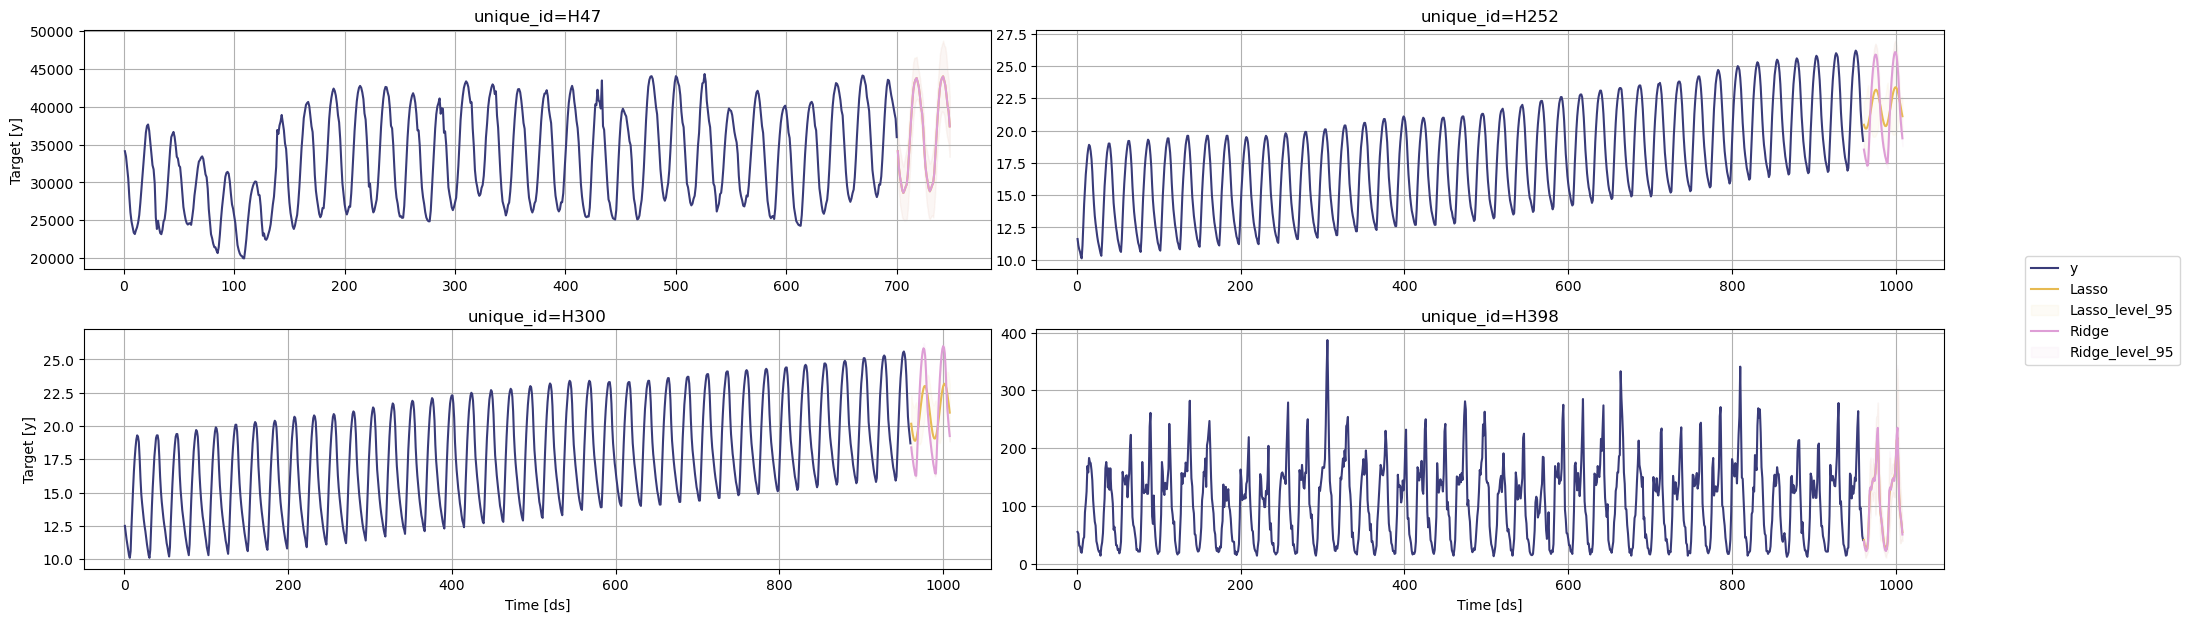

In [ ]:
sf = StatsForecast(
    models=[
        SklearnModel(Lasso()),
        SklearnModel(Ridge()),
    ],
    freq=1,
)
preds = sf.forecast(
    df=train_features,
    h=horizon,
    X_df=valid_features,
    prediction_intervals=ConformalIntervals(n_windows=4, h=horizon),
    level=[95],
)
plot_series(train, preds, level=[95], palette='tab20b', max_ids=4)